In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt


In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/gdrive/My Drive/Colab Notebooks/Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    #As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


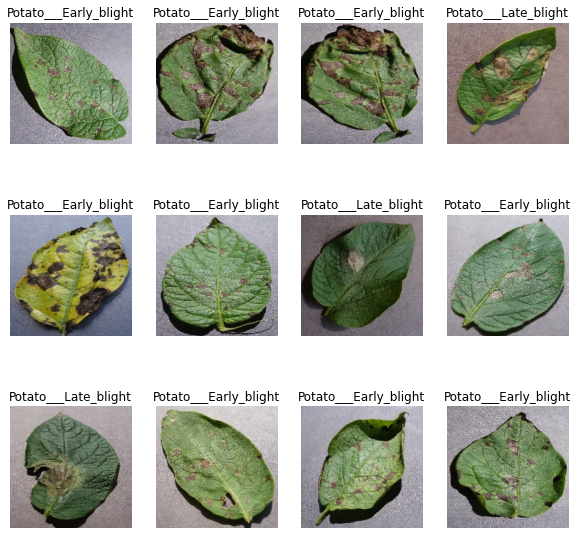

In [7]:
### Visualize some of the images from our dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [8]:
#80% is train ,10% validation used on each epochs ,10% for testing
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds=dataset.take(54)
len(train_ds)

54

In [10]:
test_ds=dataset.skip(54)# its like slicing like skip first 54
len(test_ds)

14

In [11]:
val_size=0.1
len(dataset)*val_size # we want 6 datset as validation set

6.800000000000001

In [12]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
''' Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it'''

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [18]:
#Applying Data Augmentation to Train Dataset
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
#a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 624s 422ms/step - loss: 0.8850 - accuracy: 0.4918 - val_loss: 0.7406 - val_accuracy: 0.6667
Epoch 2/50
54/54 [==============================] - 26s 406ms/step - loss: 0.6124 - accuracy: 0.7171 - val_loss: 0.7201 - val_accuracy: 0.6964
Epoch 3/50
54/54 [==============================] - 26s 402ms/step - loss: 0.5018 - accuracy: 0.7836 - val_loss: 0.6124 - val_accuracy: 0.7552
Epoch 4/50
54/54 [==============================] - 27s 410ms/step - loss: 0.4356 - accuracy: 0.8087 - val_loss: 0.3884 - val_accuracy: 0.8490
Epoch 5/50
54/54 [==============================] - 26s 399ms/step - loss: 0.2473 - accuracy: 0.8967 - val_loss: 0.1607 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 26s 403ms/step - loss: 0.2325 - accuracy: 0.9149 - val_loss: 0.1301 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 26s 399ms/step - loss: 0.1568 - accuracy: 0.9407 - val_loss: 0.1317 - val_accuracy: 0.937

In [23]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 5s 49ms/step - loss: 0.0292 - accuracy: 0.9805


In [24]:
scores

[0.029233137145638466, 0.98046875]

In [25]:
history.params

{'epochs': 50, 'steps': 54, 'verbose': 1}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

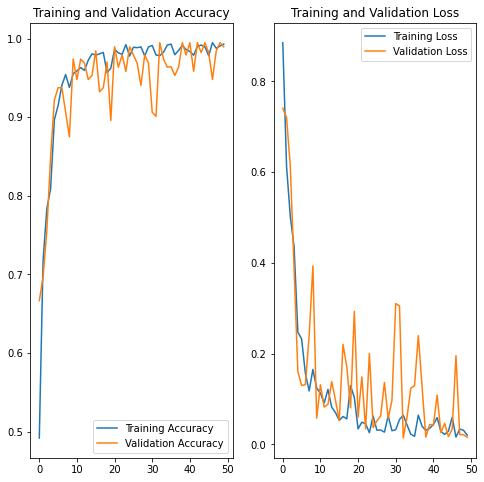

In [28]:

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
predicted label: Potato___Late_blight


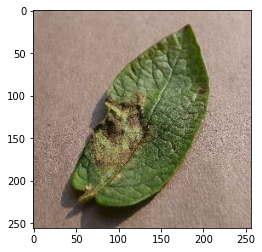

In [29]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [30]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

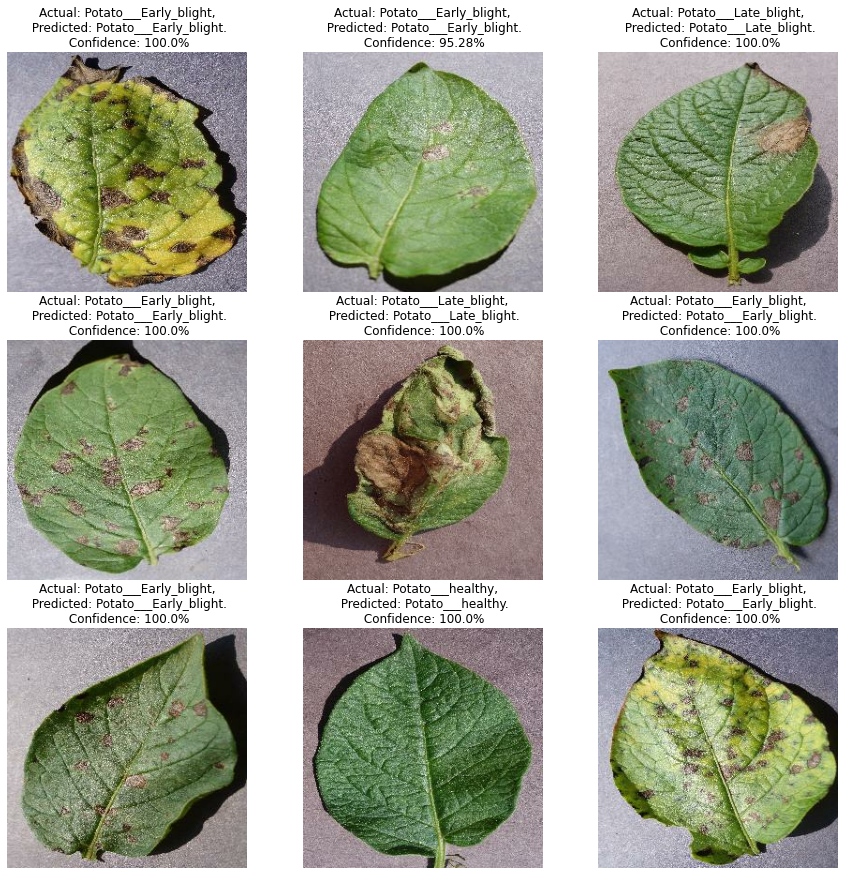

In [31]:

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")